In [156]:
from tqdm import tqdm_notebook as tqdm

from time import time
import json
from glob import glob
from pprint import pprint
import io
import os
from tqdm import tqdm_notebook as tqdm

import math
import pandas as pd

from collections import Counter, defaultdict, OrderedDict

from fuzzywuzzy import fuzz

import spacy
import nltk
import string

nlp = spacy.load('en')

In [21]:
json_files = glob('data/cvl_formatted/*.json')

def load_file(fname):
    return json.load(io.open(fname, 'r', encoding='utf-8-sig'))

data = {os.path.basename(fname)[:-5]: load_file(fname) for fname in tqdm(json_files)}

len(data)

2273

In [59]:
master_word_counter = Counter()
master_noun_counter = Counter()
tf_words = {key:Counter() for key in data.keys()}
tf_nouns = {key:Counter() for key in data.keys()}
word_idf = Counter()
noun_idf = Counter()

In [233]:
data['10809618']

{'aid': '10809618',
 'title': 'Global Methodology And Assumptions: Assessing Pools Of Residential Loans',
 'top_domain': 'Structured Finance',
 'bottom_domain': 'RMBS',
 'pub_date': 'Jan 25, 2019',
 'link': 'www.capitaliq.com/CIQDotNet/CreditResearch/SPResearch.aspx?DocumentId=10809618&From=SNP_CRS',
 'content': '  Guidance | Criteria | Structured Finance | RMBS:  Global Methodology And Assumptions: Assessing Pools Of Residential Loans    ( Editor\'s note: This guidance article was updated to include guidance for the U.K. on May 24, 2019. There were no changes to the guidance for Argentina or Mexico at that time.)  Table of Contents  Overview And Scope              Paragraphs: 1-2 Country-Specific Guidance       Paragraphs: 3-101 Argentina                       Paragraphs: 3-14 Mexico                          Paragraphs: 15-48 The U.K.                        Paragraphs: 49-101  Overview And Scope  1. This document relates to S&P Global Ratings\' criteria " ~~** Global Methodology And A

In [61]:

for key, content in tqdm(data.items()):
    doc = nlp(content['content'])

    # all tokens that arent stop words or punctuations
    words = [token.lemma_.lower() for token in doc if token.is_stop != True and token.is_punct != True]

    # noun tokens that arent stop words or punctuations
    nouns = [token.lemma_.lower() for token in doc if token.is_stop != True and token.is_punct != True and token.pos_ == "NOUN"]

    # five most common tokens
    word_freq = Counter(words)
    tf_words[key] += word_freq
    master_word_counter += word_freq
    for w in word_freq:
        word_idf[w] += 1
#     common_words = word_freq.most_common(5)

    # five most common noun tokens
    noun_freq = Counter(nouns)
    tf_nouns[key] += noun_freq
    master_noun_counter += noun_freq
    for n in noun_freq:
        noun_idf[n] += 1
#     common_nouns = noun_freq.most_common(5)


In [97]:
master_noun_counter.most_common(100)

[('rating', 66868),
 ('risk', 61096),
 ('credit', 44781),
 ('criterion', 36904),
 ('loan', 36639),
 ('asset', 33352),
 ('company', 32817),
 ('debt', 29241),
 ('transaction', 29044),
 ('market', 28185),
 ('analysis', 25716),
 ('rate', 24954),
 ('table', 23823),
 ('cash', 22586),
 ('interest', 21567),
 ('level', 21439),
 ('capital', 20960),
 ('default', 20749),
 ('security', 20733),
 ('loss', 19718),
 ('payment', 19133),
 ('factor', 19019),
 ('assessment', 17710),
 ('issuer', 17409),
 ('term', 16108),
 ('flow', 15937),
 ('business', 14942),
 ('case', 14548),
 ('pool', 14325),
 ('obligation', 13955),
 ('year', 13695),
 ('mortgage', 13669),
 ('value', 13646),
 ('investment', 13502),
 ('bank', 13443),
 ('time', 13361),
 ('cost', 12676),
 ('fund', 12479),
 ('property', 12253),
 ('management', 12134),
 ('example', 12096),
 ('industry', 11940),
 ('issue', 11892),
 ('assumption', 11826),
 ('bond', 11272),
 ('entity', 11161),
 ('liquidity', 11152),
 ('adjustment', 10782),
 ('period', 10730),
 ('

In [65]:
len(master_noun_counter)

10428

In [66]:
# noun_idf['risk']

In [67]:
_word_counter = list(master_noun_counter.most_common())
_noun_idf = list(noun_idf.most_common())

In [40]:
# import pickle
# with open('./data/word_counter.pkl', 'wb') as f:
#     pickle.dump((_word_counter, tf_nouns, master_noun_counter, tf_words, master_word_counter, word_idf, noun_idf), f)

In [63]:
# import pickle
# with open('./data/cvlbow_lemma.pkl', 'wb') as f:
#     pickle.dump((master_noun_counter, master_word_counter, tf_nouns, tf_words, noun_idf, word_idf), f)

In [89]:
any(ch in string.punctuation for ch in _noun_idf[4][0])

False

In [91]:
len(list(filter(lambda x: x[1] >= 10 and not any(ch in string.punctuation+"0123456789" for ch in x[0]), _noun_idf)))

3270

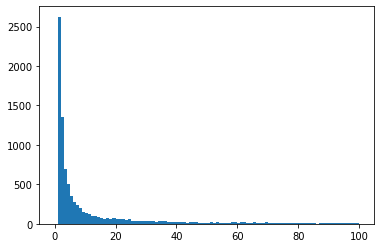

In [92]:
from matplotlib import pyplot as plt
plt.hist([v for (_, v ) in _word_counter], bins=100, range=(0, 100))
plt.show()

In [74]:
len([v for (_, v ) in _word_counter if v >= 20])

3155

In [96]:
# list(filter(lambda x: x[1] >= 10, _noun_idf))[-150:]

In [98]:
filterd_nouns = list(filter(lambda x: x[1] >= 10 and not any(ch in string.punctuation+"0123456789" for ch in x[0]), _noun_idf))

In [99]:
len(filterd_nouns)

3270

In [128]:
def tfidf(tf, df):
    if tf == 0:
        return 0.
    tf_term = 1 + math.log(tf)
    idf_term = math.log(1 + 2273. / df)
    return tf_term * idf_term

In [129]:
# noun_idf.keys()
noun_idf[filterd_nouns[0][0]]

2231

In [234]:
pd_data = []

for fname in tqdm(tf_nouns):
    nf = tf_nouns[fname]
    title = data[fname]['title']
    jdata = [('ARTICLE_ID', fname), ('TITLE', title)] + [(word[0], tfidf(tf_nouns[fname][word[0]], noun_idf[word[0]])) for word in filterd_nouns] 
    jdata += [('t_dom',data[fname]['top_domain']), ('b_dom', data[fname]['bottom_domain'])]
    pd_data.append(OrderedDict(jdata))
    

In [235]:
df = pd.DataFrame(pd_data)
df.head()

,ARTICLE_ID,TITLE,rating,credit,criterion,risk,result,market,article,issuer,...,epidemic,q,tour,defaulter,severance,gallon,mercy,jump,t_dom,b_dom
0,18350465,Framework For Credit Analysis In European CMBS...,2.448203,2.853287,1.503871,2.907029,1.554576,1.776164,1.562573,1.952970,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Structured Finance,CMBS
1,27198722,Request For Comment: Key Credit Factors For Po...,1.833172,2.615916,3.444467,4.061472,2.068035,4.101837,0.744574,1.267195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Corporates,Request for Comment
2,35464774,Request For Comment: Foreign Exchange Risk In ...,2.504434,1.683458,2.898316,2.825056,1.254222,1.776164,2.193449,0.748426,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Structured Finance,Request for Comment
3,18570420,Facing Up to the Rating Challenges of Whole Co...,2.387076,1.840879,1.503871,2.356336,1.554576,2.292087,1.260674,1.785964,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Structured Finance,ABS
4,18076851,Rating U.S. Residential Asset-Backed Mortgage...,2.163357,2.782681,2.206736,2.825056,0.000000,3.045040,0.744574,1.570655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Structured Finance,ABCP


In [236]:
df.to_csv('data/cvl_tfidf_with_title.csv')

In [148]:
# LINKING

In [149]:
len(data)

2273

In [158]:
keys = data.keys()
list_of_links = {key: data[key]['refs'] for key in data}

keys

dict_keys(['18350465', '27198722', '35464774', '18570420', '18076851', '18286174', '27211545', '18542947', '18490280', '28699519', '18380511', '18455660', '18373169', '18147644', '26598919', '18567648', '28993151', '18249571', '42573271', '33039745', '18135740', '18419289', '18455637', '38215323', '18528435', '18467316', '18448140', '18185865', '18206219', '18315757', '18105899', '18296070', '18522612', '38006442', '18479488', '39770454', '29134276', '18490412', '18402129', '18448290', '18403368', '36326831', '18387016', '18070751', '41563244', '18171222', '41553758', '39174267', '27043786', '18300113', '18475278', '18332432', '18530382', '18058915', '18283225', '18522645', '18087917', '41854300', '18514262', '18363256', '26778704', '18545514', '27043694', '18417956', '18482614', '29572556', '28890999', '18237342', '18326774', '29998276', '18242757', '18115323', '18517120', '18350408', '18248589', '18405506', '28056886', '41673378', '41426453', '28993612', '18105909', '38994808', '3405

In [175]:
list_of_links['18460739']

[{'LINK': 'www.capitaliq.com/CIQDotNet/CreditResearch/SPResearch.aspx?articleId=&ArtObjectId=10950501&ArtRevId=1&sid=&sind=A&',
  'LINK_TEXT': 'U.S. Structured Finance Asset Isolation And Special-Purpose Entity Criteria',
  'ART_OBJECTID': '10950501'},
 {'LINK': 'www.capitaliq.com/CIQDotNet/CreditResearch/SPResearch.aspx?articleId=&ArtObjectId=5531630&ArtRevId=3&sid=&sind=A&',
  'LINK_TEXT': 'Securitizations By Code Transferors',
  'ART_OBJECTID': '5531630'},
 {'LINK': 'www.capitaliq.com/CIQDotNet/CreditResearch/SPResearch.aspx?articleId=&ArtObjectId=5532219&ArtRevId=3&sid=&sind=A&',
  'LINK_TEXT': 'Securitizations By SPE Transferors And Non-Code Transferors',
  'ART_OBJECTID': '5532219'},
 {'LINK': 'www.capitaliq.com/CIQDotNet/CreditResearch/SPResearch.aspx?articleId=&ArtObjectId=5536184&ArtRevId=3&sid=&sind=A&',
  'LINK_TEXT': 'Legal Criteria For U.S. Structured Finance Transactions: Special-Purpose Entities',
  'ART_OBJECTID': '5536184'},
 {'LINK': 'www.capitaliq.com/CIQDotNet/Credi

In [173]:
# data['18460739']['title']

In [186]:
# (me_id, link_id)
refs4 = []


for key in tqdm(list_of_links):
    title = data[key]['title']
    for link in list_of_links[key]:
        link_title = link['LINK_TEXT']
        for new_key in data:
            if fuzz.ratio(link_title, data[new_key]['title']) == 100:
                refs4.append((key, new_key))




In [183]:
len(refs) # > 90

31431

In [228]:
len(set(refs))

19210

In [229]:
len(set(refs2)) # > 95

16977

In [230]:
len(set(refs3)) # > 98

15691

In [231]:
len(set(refs4)) # == 100

14442

In [194]:
# len(refs4) / (2273*2273)

In [197]:
# refs4[:100]

In [225]:
# refs4[:10]

refs_pd = [{'citing':key[0], 'cited':key[1]} for key in set(refs4)]

refs_df = pd.DataFrame(refs_pd)

refs_df.to_csv('data/cvl_cites_100.csv')

In [226]:
# citation_df =

In [227]:
refs_df

,citing,cited
0,31582169,26357686
1,33604991,18311982
2,27043861,28993375
3,26778704,35828942
4,33121188,27043789
...,...,...
14437,18309364,18469887
14438,28460281,41960122
14439,29237465,18291358
14440,31506545,31506536
